# SWE results: temporary analysis of full outputs

## Initialising data and getting things set up

Here we first define some helper functions and the like, to be used later on. We also import libraries and some definitions for the figure sizes:

In [21]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from glob import glob
from tabulate import tabulate

import sys
sys.path.insert(0, "../src")
from figures import figure_sizes, texp

def errors_from_output_file(output_file, prior=False):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    s = checkpoint["/"].attrs["s"]
    nx_obs = checkpoint["/"].attrs["nx_obs"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 2e-3
    
    t_obs = checkpoint["/t_obs"][:]

    # HACK(connor): get analysis to work with misaligned times
    failed_sim = False
    if t_obs[-1] == 0.:
        failed_sim = True
        idx_failed = t_obs > 0
    
    if failed_sim:
        t_obs = t_obs[idx_failed]
        rmse = checkpoint["/rmse"][idx_failed]
    else:
        rmse = checkpoint["/rmse"][:]
        
    # coordinates
    coords = dict(t=t_obs,
                  nu=np.array([nu]),
                  s=np.array([s]),
                  nx_obs=np.array([nx_obs]),
                  nt_skip=np.array([nt_skip]))

    # load in errors etc
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis],
                               coords=coords, name="rmse")
    if not prior:
        if failed_sim:
            lml = checkpoint["/lml"][idx_failed]
        else:
            lml = checkpoint["/lml"][:]

        checkpoint.close()
        lml_ds = xr.DataArray(data=lml[:, np.newaxis, np.newaxis, np.newaxis, np.newaxis],
                              coords=coords, name="lml")
        return xr.merge([rmse_ds, lml_ds])
    else:
        checkpoint.close()
        return xr.merge([rmse_ds])
    
    
def build_output_ds(output_files, prior=False):
    errors_ds = []
    for output_file in output_files:
        e = errors_from_output_file(output_file, prior=prior)
        errors_ds.append(e)

    errors = xr.merge(errors_ds)
    return errors

## Analysis of posteriors: fixed number of spatial observations

In [22]:
output_files_post = glob(
    "../outputs/swe-tidal-redo-sparse/nonlinear-posterior-*-nx_obs-5-*")

errors_post = build_output_ds(output_files_post, prior=False)
print(errors_post)

<xarray.Dataset>
Dimensions:  (t: 43200, nu: 5, s: 5, nx_obs: 1, nt_skip: 5)
Coordinates:
  * t        (t) float64 1.0 2.0 3.0 4.0 ... 4.32e+04 4.32e+04 4.32e+04 4.32e+04
  * nu       (nu) float64 1.0 1e+03 1e+04 5e+04 1e+05
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 5
  * nt_skip  (nt_skip) int64 1 30 60 120 180
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.01948 0.01948 ... nan nan
    lml      (t, nu, s, nx_obs, nt_skip) float64 -748.4 -748.4 ... nan nan


In [23]:
output_files_prior = glob(
    "../outputs/swe-tidal-redo-sparse/nonlinear-prior-*.h5")

output_files_linear_prior = glob(
    "../outputs/swe-tidal-redo-sparse/linear-prior-*.h5")

errors_prior = build_output_ds(output_files_prior, prior=True)
errors_linear_prior = build_output_ds(output_files_linear_prior, 
                                      prior=True)

print(errors_prior)
print(errors_linear_prior)

<xarray.Dataset>
Dimensions:  (t: 1440, nu: 5, s: 5, nx_obs: 3, nt_skip: 1)
Coordinates:
  * t        (t) float64 1.0 31.0 61.0 91.0 ... 4.311e+04 4.314e+04 4.317e+04
  * nu       (nu) float64 1.0 1e+03 1e+04 5e+04 1e+05
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 30
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02159 0.02127 ... 0.5446
<xarray.Dataset>
Dimensions:  (t: 1440, nu: 5, s: 5, nx_obs: 3, nt_skip: 1)
Coordinates:
  * t        (t) float64 1.0 31.0 61.0 91.0 ... 4.311e+04 4.314e+04 4.317e+04
  * nu       (nu) float64 1.0 1e+03 1e+04 5e+04 1e+05
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 30
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02159 0.02127 ... 0.5442


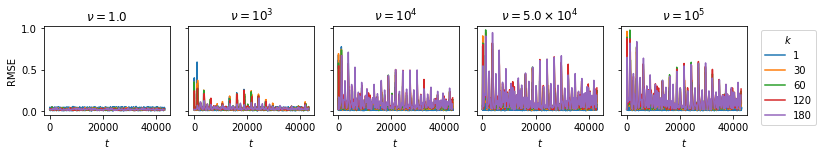

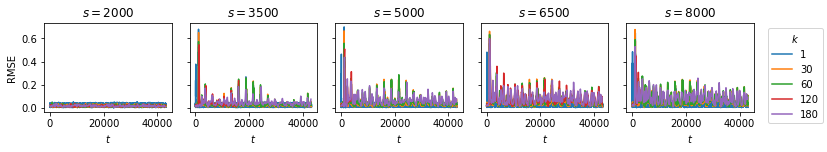

In [24]:
nus =  errors_post.coords["nu"].to_numpy()
nu_labels = [fr"$\nu = {texp(f'{nu:.1e}', False)}$" for nu in nus]

p = errors_post.rmse.isel(nx_obs=0, s=0).interpolate_na(dim="t").plot(
    hue="nt_skip", col="nu",
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

# figure customization
p.figlegend.set_title(r"$k$")
# p.figlegend.remove()

for i, ax in enumerate(p.axes.flat):
    ax.set_title(nu_labels[i])
    # ax.set_yscale("log")

for ax in p.axes[0, :]:
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE")
plt.show()

p = errors_post.rmse.isel(nx_obs=0, nu=0).interpolate_na(dim="t").plot(
    hue="nt_skip", col="s", col_wrap=5,
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

# figure customization
p.figlegend.set_title(r"$k$")

s_all =  errors_post.coords["s"].to_numpy()
s_labels = [fr"$s = {s:.0f}$" for s in s_all]
for i, ax in enumerate(p.axes.flat):
    ax.set_title(s_labels[i])
    # ax.set_yscale("log")

for ax in p.axes[-1, :].flat:
    ax.set_xlabel(r"$t$")

p.axes[0, 0].set_ylabel("RMSE") 
plt.show()

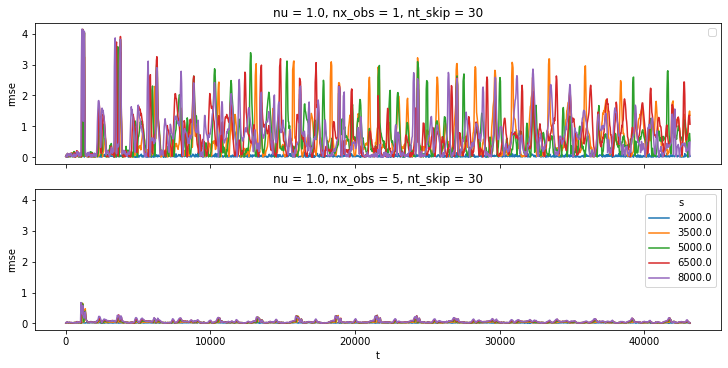

In [27]:
fig, ax = plt.subplots(2, 1,  
                       constrained_layout=True, figsize=(10, 5),
                       sharex=True, sharey=True)
p = errors_prior.rmse.isel(nx_obs=0, nu=0).interpolate_na(dim="t").plot(hue="s", ax=ax[0])
ax[0].legend([])
ax[0].set_xlabel("")

p = errors_post.rmse.isel(nx_obs=0, nu=0, nt_skip=1).interpolate_na(dim="t").plot(hue="s", ax=ax[1])
plt.show()

In [28]:
ave_rmse = errors_post.isel(nx_obs=0, s=1).mean(dim="t", skipna=True).rmse
dat = ave_rmse.to_numpy().T

from scipy.stats import f_oneway

print(f_oneway(*[col for col in dat.T]))
print(tabulate(dat,
               ave_rmse.coords["nu"].to_numpy(),
               showindex=ave_rmse["nt_skip"].to_numpy()))
                 
def format_col(col, exp=False):
    min_loc = col.argmin()
    out = col.astype(str)
    
    for i in range(len(col)):
        if i == min_loc:
            if exp:
                out[i] = fr"$\mathbf{{{col[i]:.6e}}}$"
            else:
                out[i] = fr"$\mathbf{{{col[i]:.6f}}}$"
        else:
            if exp:
                out[i] = fr"${col[i]:.6e}$"
            else:
                out[i] = fr"${col[i]:.6f}$"

    return np.array(out)
            
dat_formatted = np.apply_along_axis(format_col, 0, dat)

with open("../figures/nt-skip-nu-table.tex", "w") as f:
    f.write(tabulate(dat_formatted,
                     ave_rmse.coords["nu"].to_numpy(),
                     showindex=ave_rmse["nt_skip"].to_numpy(),
                     tablefmt="latex_raw"))

F_onewayResult(statistic=6.8683674052295824, pvalue=0.0011952968937275791)
           1.0     1000.0    10000.0    50000.0    100000.0
---  ---------  ---------  ---------  ---------  ----------
  1  0.0265577  0.0293449  0.0373879  0.0428853   0.0424712
 30  0.035493   0.040606   0.0816403  0.106923    0.102194
 60  0.0388439  0.0443499  0.0958595  0.126034    0.118605
120  0.0504422  0.0491391  0.110637   0.145609    0.133501
180  0.0451508  0.0515861  0.116642   0.151014    0.135885


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


In [29]:
ave_rmse = errors_post.isel(nx_obs=0, nu=1).mean(dim="t", skipna=True).rmse

dat = ave_rmse.to_numpy().T
print(f_oneway(*[col for col in dat.T]))

print(tabulate(dat, 
               ave_rmse.coords["s"].to_numpy(),
               showindex=ave_rmse["nt_skip"].to_numpy()))

dat_formatted = np.apply_along_axis(format_col, 0, dat)

with open("../figures/nt-skip-c-table.tex", "w") as f:
    f.write(tabulate(dat_formatted, 
                     ave_rmse.coords["s"].to_numpy(),
                     showindex=ave_rmse["nt_skip"].to_numpy(),
                     tablefmt="latex_raw"))

F_onewayResult(statistic=6.001560924712845, pvalue=0.0024269789896324894)
        2000.0     3500.0     5000.0     6500.0     8000.0
---  ---------  ---------  ---------  ---------  ---------
  1  0.027464   0.0293449  0.0322796  0.0342398  0.0356717
 30  0.0321737  0.040606   0.0552164  0.0671275  0.0750457
 60  0.0332761  0.0443499  0.0630962  0.0774676  0.0865923
120  0.0347763  0.0491391  0.0714394  0.0871852  0.0962277
180  0.0316445  0.0515861  0.0761019  0.092182   0.100177


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


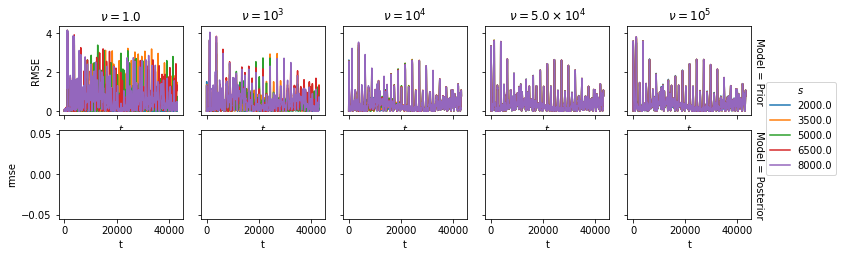

In [32]:
errors_temp = xr.concat([errors_prior, errors_post], 
                        pd.Index(["Prior", "Posterior"], name="Model"))

p = errors_temp.rmse.interpolate_na(dim="t").isel(nx_obs=0, nt_skip=1).plot(
    x="t", col="nu", hue="s", row="Model",
    figsize=(1.5 * figure_sizes["fullwidth"], 0.5 * figure_sizes["fullwidth"]),
    sharex=True, sharey="row")

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])

for ax in p.axes[0, :]:
    ax.set_xlabel(r"$t$")
    
p.axes[0, 0].set_ylabel("RMSE")
p.figlegend.set_title("$s$")
plt.show()

In [33]:
errors_subset = errors_post.copy()
errors_subset["lml"] *= -1  # convert to negative LML
errors_subset_array = errors_subset.to_array("metric")

errors_subset

<xarray.Dataset>
Dimensions:  (t: 43200, nu: 5, s: 5, nx_obs: 1, nt_skip: 5)
Coordinates:
  * t        (t) float64 1.0 2.0 3.0 4.0 ... 4.32e+04 4.32e+04 4.32e+04 4.32e+04
  * nu       (nu) float64 1.0 1e+03 1e+04 5e+04 1e+05
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 5
  * nt_skip  (nt_skip) int64 1 30 60 120 180
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.01948 0.01948 ... nan nan
    lml      (t, nu, s, nx_obs, nt_skip) float64 748.4 748.4 748.4 ... nan nan

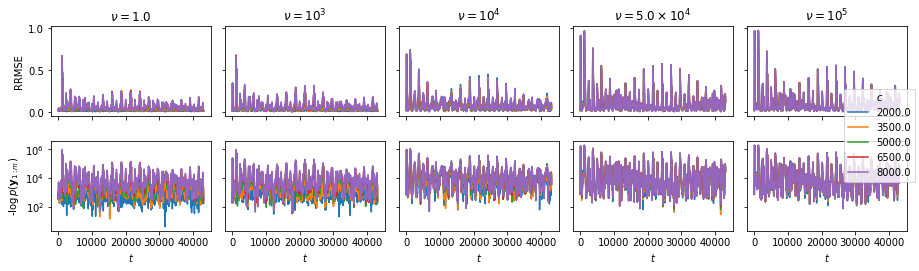

In [36]:
p = errors_subset_array.interpolate_na(dim="t").isel(nx_obs=0, nt_skip=1).plot(
    x="t", col="nu", hue="s", row="metric",
    figsize=(1.6 * figure_sizes["fullwidth"], 
             0.5 * figure_sizes["fullwidth"]),
    sharex=True, sharey="row")
p.set_titles("")
plt.tight_layout()

nus =  errors_subset.coords["nu"].to_numpy()
labels = [fr"$\nu =$ {nu:.1e}" for nu in nus]
labels[0] = "Linear"

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])
    # ax.set_yscale("log")

for ax in p.axes[1, :]:
    ax.set_yscale("log")
    ax.set_xlabel(r"$t$")

p.axes[0, 0].set_ylabel("RRMSE")
p.axes[1, 0].set_ylabel(r"-$\log p(\mathbf{y}_{1:m})$")

p.figlegend.set_title("$c$")
p.fig.savefig("../figures/nu-c-rrmse-nlml-layout.pdf", 
              bbox_inches="tight")
plt.show()

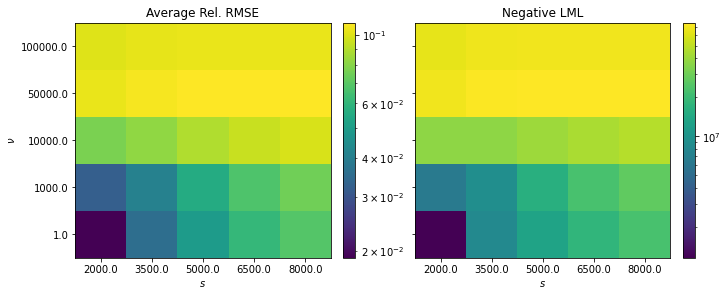

In [37]:
import matplotlib.colors as colors

# mean the RMSEs, sum the LMLs
total_rmse = errors_post.isel(nx_obs=0, nt_skip=1).mean(dim="t").rmse
total_lml = np.abs(errors_post.isel(nx_obs=0, nt_skip=1).lml).sum(dim="t")

rmse_array = total_rmse.to_numpy()[:, :]
lml_array = total_lml.to_numpy()[:, :]

fig, ax = plt.subplots(1, 2, 
                       figsize=(10, 4), constrained_layout=True,
                      sharey=True)
im = ax[0].pcolormesh(range(len(total_rmse.coords["s"].to_numpy())), 
                      range(len(total_rmse.coords["nu"].to_numpy())),
                      rmse_array,
                      norm=colors.LogNorm(vmin=rmse_array.min(), 
                                          vmax=rmse_array.max()))
ax[0].set_xticks(range(len(total_rmse.coords["s"].to_numpy())), 
                 total_rmse.coords["s"].to_numpy())
ax[0].set_yticks(range(len(total_rmse.coords["nu"].to_numpy())), 
                 total_rmse.coords["nu"].to_numpy())
ax[0].set_xlabel(r"$s$")
ax[0].set_ylabel(r"$\nu$")
ax[0].set_title("Average Rel. RMSE")
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(range(len(total_lml.coords["s"].to_numpy())), 
                      range(len(total_lml.coords["nu"].to_numpy())),
                      lml_array,
                      norm=colors.LogNorm(vmin=lml_array.min(), 
                                          vmax=lml_array.max()))
ax[1].set_xticks(range(len(total_lml.coords["s"].to_numpy())), 
                 total_lml.coords["s"].to_numpy())
ax[1].set_yticks(range(len(total_lml.coords["nu"].to_numpy())), 
                 total_lml.coords["nu"].to_numpy())
ax[1].set_xlabel(r"$s$")
ax[1].set_title("Negative LML")
plt.colorbar(im, ax=ax[1])

plt.savefig("../figures/nu-c-rrmse-lml-table-color.pdf", dpi=600)

In [38]:
print(tabulate(lml_array, 
               headers=total_lml.coords['s'].to_numpy(),
               showindex=total_lml.coords['nu'].to_numpy()))

lml_formatted = np.apply_along_axis(format_col, 0, lml_array, True)
with open("../figures/nu-c-lml-table.tex", "w") as f:
    f.write(tabulate(lml_formatted,
                     headers=total_lml.coords['s'].to_numpy(),
                     showindex=total_lml.coords['nu'].to_numpy(),
                     tablefmt="latex_raw"))

             2000.0       3500.0       5000.0       6500.0       8000.0
------  -----------  -----------  -----------  -----------  -----------
     1  1.15339e+06  8.23627e+06  1.30229e+07  1.78071e+07  2.21657e+07
  1000  6.36821e+06  8.85801e+06  1.59383e+07  2.23294e+07  2.70727e+07
 10000  3.67954e+07  3.71711e+07  4.04566e+07  4.43467e+07  4.74976e+07
 50000  6.82698e+07  7.29051e+07  7.47709e+07  7.49816e+07  7.4997e+07
100000  6.46546e+07  6.7109e+07   6.82311e+07  6.84264e+07  6.84536e+07


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


## Analysis of posteriors: additional observation locations

Now we analyses the posterior model results whilst varying the number of spatial observation locations. In this we fix the frequency of observations to $1/30$ Hz.

In [39]:
output_files_post = glob(
    "../outputs/swe-tidal-redo-sparse/nonlinear-posterior-*-nt_skip-30-*")

errors_post_nx = build_output_ds(output_files_post, prior=False)
print(errors_post_nx)

<xarray.Dataset>
Dimensions:  (t: 1440, nu: 5, s: 5, nx_obs: 3, nt_skip: 1)
Coordinates:
  * t        (t) float64 1.0 31.0 61.0 91.0 ... 4.311e+04 4.314e+04 4.317e+04
  * nu       (nu) float64 1.0 1e+03 1e+04 5e+04 1e+05
  * s        (s) float64 2e+03 3.5e+03 5e+03 6.5e+03 8e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 30
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02156 0.02125 ... 0.1078
    lml      (t, nu, s, nx_obs, nt_skip) float64 -35.1 -140.4 ... -2.325e+04


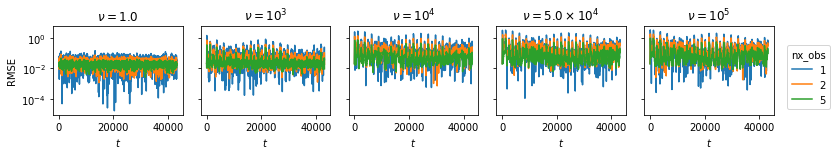

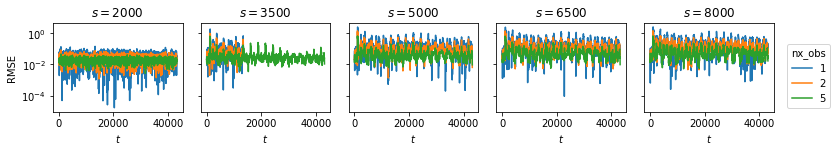

In [40]:
nus =  errors_post.coords["nu"].to_numpy()
nu_labels = [fr"$\nu = {texp(f'{nu:.1e}', False)}$" for nu in nus]

p = errors_post_nx.rmse.isel(s=0).interpolate_na(dim="t").plot(
    hue="nx_obs", col="nu",
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

for i, ax in enumerate(p.axes.flat):
    ax.set_title(nu_labels[i])
    ax.set_yscale("log")

for ax in p.axes[0, :]:
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE")
plt.show()

p = errors_post_nx.rmse.isel(nu=0).interpolate_na(dim="t").plot(
    hue="nx_obs", col="s", col_wrap=5,
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

s_all =  errors_post.coords["s"].to_numpy()
s_labels = [fr"$s = {s:.0f}$" for s in s_all]
for i, ax in enumerate(p.axes.flat):
    ax.set_title(s_labels[i])
    ax.set_yscale("log")

for ax in p.axes[-1, :].flat:
    ax.set_xlabel(r"$t$")

p.axes[0, 0].set_ylabel("RMSE") 
plt.show()

In [41]:
ave_rmse = errors_post_nx.isel(nu=0, nt_skip=0).mean(dim="t", skipna=True).rmse
dat = ave_rmse.to_numpy().T
print(f_oneway(*[col for col in dat.T]))

print(tabulate(dat, 
               ave_rmse.coords["s"].to_numpy(),
               showindex=ave_rmse["nx_obs"].to_numpy()))
print("\n")

ave_rmse = errors_post_nx.isel(s=0, nt_skip=0).mean(dim="t", skipna=True).rmse
dat = ave_rmse.to_numpy().T
print(f_oneway(*[col for col in dat.T]))

print(tabulate(dat, 
               ave_rmse.coords["nu"].to_numpy(),
               showindex=ave_rmse["nx_obs"].to_numpy()))

F_onewayResult(statistic=2.0439982478171066, pvalue=0.16378526933137108)
       2000.0     3500.0     5000.0     6500.0     8000.0
--  ---------  ---------  ---------  ---------  ---------
 1  0.0290656  0.12316    0.196452   0.234589   0.254838
 2  0.0248805  0.0802481  0.117387   0.150127   0.171282
 5  0.0190158  0.035493   0.0494129  0.0609206  0.0686777


F_onewayResult(statistic=4.838249295048933, pvalue=0.019717974454768528)
          1.0     1000.0    10000.0    50000.0    100000.0
--  ---------  ---------  ---------  ---------  ----------
 1  0.0290656  0.0764773  0.229435    0.273075    0.249647
 2  0.0248805  0.0558875  0.169302    0.235482    0.226535
 5  0.0190158  0.0321737  0.0770339   0.103083    0.100246


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:
/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


## Analysis of observations: varying observation frequency in time vs space

We now look at results for a mildly misspecified case: $s = 3500$, $\nu = 1$, to see what happens as you increase observation frequency in time and space.

In [42]:
output_files_post = glob(
    "../outputs/swe-tidal-redo-sparse/nonlinear-posterior-s-8000.0-*-nu-1.00e+00*")

errors_post_st = build_output_ds(output_files_post, prior=False)
print(errors_post_st)

<xarray.Dataset>
Dimensions:  (t: 43200, nu: 1, s: 1, nx_obs: 3, nt_skip: 5)
Coordinates:
  * t        (t) float64 1.0 2.0 3.0 4.0 ... 4.32e+04 4.32e+04 4.32e+04 4.32e+04
  * nu       (nu) float64 1.0
  * s        (s) float64 8e+03
  * nx_obs   (nx_obs) int64 1 2 5
  * nt_skip  (nt_skip) int64 1 30 60 120 180
Data variables:
    rmse     (t, nu, s, nx_obs, nt_skip) float64 0.02156 0.02156 ... nan nan
    lml      (t, nu, s, nx_obs, nt_skip) float64 -35.1 -35.1 -35.1 ... nan nan


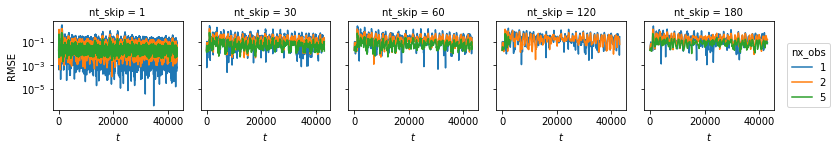

In [43]:
p = errors_post_st.rmse.isel(nu=0, s=0).interpolate_na(dim="t").plot(
    hue="nx_obs", col="nt_skip",
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

for ax in p.axes.flat:
    ax.set_yscale("log")

for ax in p.axes[0, :]:
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE")
plt.show()

In [44]:
ave_rmse = errors_post_st.isel(nu=0, s=0).mean(dim="t", skipna=True).rmse
dat = ave_rmse.to_numpy().T
print(f_oneway(*[col for col in dat.T]))

print(tabulate(dat, 
               ave_rmse.coords["nx_obs"].to_numpy(),
               showindex=ave_rmse["nt_skip"].to_numpy()))

F_onewayResult(statistic=7.618989788249461, pvalue=0.007312032900989951)
             1          2          5
---  ---------  ---------  ---------
  1  0.0886655  0.0600318  0.0334366
 30  0.254838   0.171282   0.0686777
 60  0.265232   0.199815   0.0769935
120  0.265886   0.218434   0.110831
180  0.253111   0.230238   0.0905698


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


## Analysis of posteriors: linear approximation

In [45]:
output_files_post = glob(
    "../outputs/swe-tidal-redo-sparse/linear-posterior-*-nx_obs-1-*")

errors_linear_post = build_output_ds(output_files_post, prior=False)
print(errors_linear_post)

KeyError: "Can't open attribute (can't locate attribute: 'nu')"

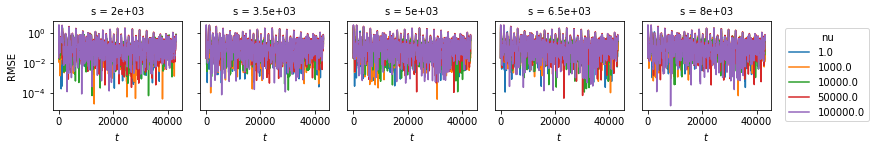

In [20]:
p = errors_linear_post.rmse.isel(nx_obs=0, nt_skip=1).interpolate_na(dim="t").plot(
    hue="nu", col="s",
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

for ax in p.axes.flat:
    ax.set_yscale("log")

for ax in p.axes[0, :]:
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RMSE")
plt.show()